In [1]:
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from pathlib import Path
from helpers.utils import LaughterDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
# Load labels and add numerical mapping to laugh class
labels = pd.read_csv('data/labels.csv')
mappings = {'belly': 0, 'chuckle': 1, 'baby': 2, 'evil': 3} 
labels['laugh_numerical'] = labels['laugh_class'].map(mappings)

In [ ]:
ROOT_PATH = Path('data/training-dataset')

# Split between training (75%) and testing (25%) labels 
training_labels, testing_labels = train_test_split(labels, train_size=0.75, test_size=0.25)

# This will return datasets splited between training and labels
training_dataset = LaughterDataset(ROOT_PATH, labels=training_labels)
testing_dataset = LaughterDataset(ROOT_PATH, labels=testing_labels)

# Creating Dataloaders for Neural Network
train_loader = DataLoader(training_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=8, shuffle=False)

In [18]:
class LaughCNN(nn.Module):
	def __init__(self):
		super(LaughCNN, self).__init__()
		self.conv = nn.Sequential(
			nn.Conv2d(1, 16, kernel_size=3, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2),
			nn.Conv2d(16, 32, kernel_size=3, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2)
		)
		self.fc = nn.Sequential(
			nn.Flatten(),
			nn.Linear(32 * 3 * 32, 64),
			nn.ReLU(),
			nn.Linear(64, 4)
		)

	def forward(self, x):
		x = self.conv(x)
		return self.fc(x)

In [19]:
model = LaughCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_for_iteration = []

for epoch in range(30):
	model.train()
	running_loss = 0.0
	for audio, _, _, numerical in train_loader:
			outputs = model(audio)
			loss = criterion(outputs, numerical)

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			running_loss += loss.item()
	loss_for_iteration.append(running_loss/len(train_loader))

	print(f"Epoch {epoch+1}: Loss = {running_loss/len(train_loader):.4f}")

Epoch 1: Loss = 5.7408
Epoch 2: Loss = 0.9406
Epoch 3: Loss = 0.7503
Epoch 4: Loss = 0.4623
Epoch 5: Loss = 0.4415
Epoch 6: Loss = 0.2930
Epoch 7: Loss = 0.2058
Epoch 8: Loss = 0.1048
Epoch 9: Loss = 0.0708
Epoch 10: Loss = 0.0400
Epoch 11: Loss = 0.0217
Epoch 12: Loss = 0.0140
Epoch 13: Loss = 0.0094
Epoch 14: Loss = 0.0072
Epoch 15: Loss = 0.0064
Epoch 16: Loss = 0.0050
Epoch 17: Loss = 0.0040
Epoch 18: Loss = 0.0034
Epoch 19: Loss = 0.0030
Epoch 20: Loss = 0.0025
Epoch 21: Loss = 0.0020
Epoch 22: Loss = 0.0018
Epoch 23: Loss = 0.0016
Epoch 24: Loss = 0.0015
Epoch 25: Loss = 0.0014
Epoch 26: Loss = 0.0013
Epoch 27: Loss = 0.0012
Epoch 28: Loss = 0.0010
Epoch 29: Loss = 0.0009
Epoch 30: Loss = 0.0008


In [20]:
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
		for audio, audio_id, _, numerical in test_loader:
				outputs = model(audio)
				_, predicted = torch.max(outputs, 1)
				predictions.extend(p.item() for p in predicted)
				true_labels.extend(n.item() for n in numerical)
				
print(f'{'Predicted':>{10}}: {predictions}')
print(f'{'True':>{10}}: {true_labels:}')

# print("Classification Report:")
# print(classification_report(labels, preds, target_names=["chuckle", "baby"]))
# print("Confusion Matrix:")
# print(confusion_matrix(labels, preds))

 Predicted: [0, 0, 2, 0, 1, 3, 2, 1, 2, 2, 1, 0, 1, 0, 0, 3, 2, 0, 0, 3, 3, 0, 0, 0, 1, 3, 3, 0, 2, 1, 3, 2, 1, 3, 1, 3, 0, 1, 1, 0, 3, 0, 0, 2, 3, 0, 3, 3, 1, 1, 0, 1, 2, 3, 2, 1, 0, 1, 2, 1, 3, 0, 0, 3, 1, 0]
      True: [0, 0, 2, 0, 1, 3, 3, 1, 2, 2, 0, 3, 1, 0, 1, 0, 2, 0, 0, 3, 3, 0, 0, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 0, 1, 3, 0, 1, 2, 3, 1, 2, 0, 3, 3, 0, 3, 2, 1, 1, 0, 1, 3, 3, 2, 3, 0, 1, 2, 1, 1, 0, 2, 3, 2, 0]


In [21]:

accuraccy = accuracy_score(predictions, true_labels)
precision = precision_score(predictions, true_labels, average='macro')
recall = recall_score(predictions, true_labels, average='macro')
F1_score = f1_score(predictions, true_labels, average='macro')
print(accuraccy)
print(precision)
print(recall)
print(F1_score)

cm = confusion_matrix(y_true=true_labels, y_pred=predictions)

print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=["chuckle", "baby", "belly", "evil"]))
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predictions))

0.696969696969697
0.6867647058823529
0.689254679144385
0.6846428571428571
Classification Report:
              precision    recall  f1-score   support

     chuckle       0.73      0.80      0.76        20
        baby       0.71      0.80      0.75        15
       belly       0.64      0.50      0.56        14
        evil       0.69      0.65      0.67        17

    accuracy                           0.70        66
   macro avg       0.69      0.69      0.68        66
weighted avg       0.69      0.70      0.69        66

Confusion Matrix:
[[16  1  1  2]
 [ 1 12  0  2]
 [ 3  3  7  1]
 [ 2  1  3 11]]


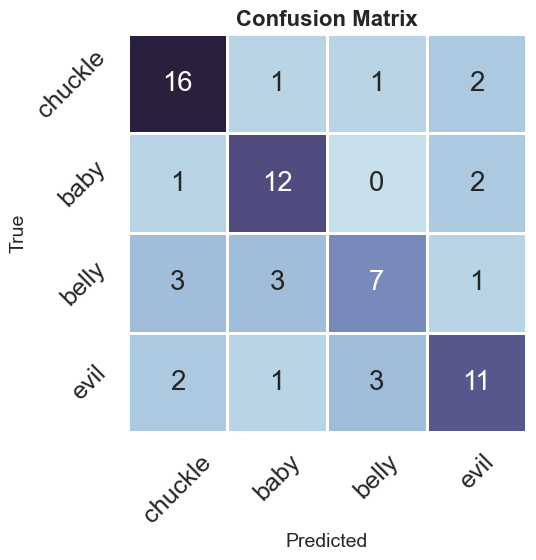

In [22]:
tags = ["chuckle", "baby", "belly", "evil"]

plt.figure(figsize=(7, 6))
cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap=cmap,
    xticklabels=tags,
    yticklabels=tags,
    linewidths=1,
    linecolor='white',
    cbar=False,
    square=True
)

ax.set_xlabel("Predicted", fontsize=14)
ax.set_ylabel("True", fontsize=14)
ax.set_title("Confusion Matrix", fontsize=16, weight='bold')

plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


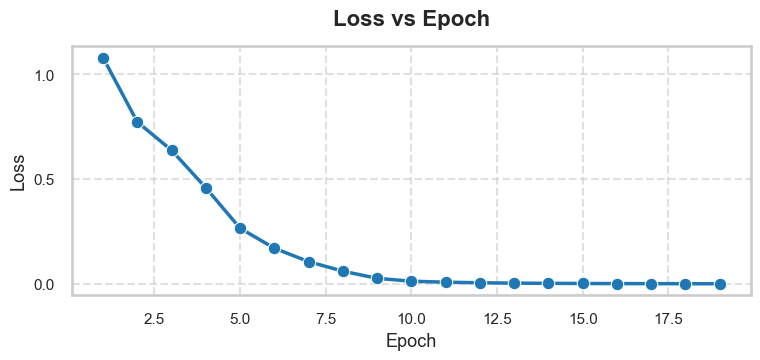

In [12]:
df = pd.DataFrame({
    'Epoch': range(1, 20),
    'Loss': loss_for_iteration[1:20]
})

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.1)
plt.figure(figsize=(8, 4))
sns.lineplot(
    data=df,
    x='Epoch',
    y='Loss',
    marker='o',
    linewidth=2.5,
    color="#1f77b4",
)

# Plot
plt.title("Loss vs Epoch", fontsize=16, weight='bold', pad=15)
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()